In [29]:
# 网格搜索 交叉验证

2.9.1
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.0
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
keras.api._v2.keras 2.9.0


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

In [30]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [31]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [33]:
# 把tensorflow模型转化封装为sklearn模型,再使用sklearn的网格搜索
def build_model(hidden_layers=1,
                layer_size=30,
                learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model


# KerasRegressor返回一个sklearn的model  build_fn是一个回调函数
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
# 测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            validation_data=(x_valid_scaled, y_valid),
                            epochs=10, callbacks=callbacks,workers=-1)

Epoch 1/10


C:\MyTempFiles\ipykernel_10496\4145860342.py:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)


363/363 [==============================] - 1s 1ms/step - loss: 1.5091 - val_loss: 0.6552
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5765 - val_loss: 0.5845
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5218 - val_loss: 0.5417
Epoch 4/10
363/363 [==============================] - 0s 973us/step - loss: 0.4900 - val_loss: 0.5169
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4732 - val_loss: 0.5025
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4638 - val_loss: 0.4850
Epoch 7/10
363/363 [==============================] - 0s 989us/step - loss: 0.4542 - val_loss: 0.4756
Epoch 8/10
363/363 [==============================] - 0s 984us/step - loss: 0.4409 - val_loss: 0.4879
Epoch 9/10
363/363 [==============================] - 0s 987us/step - loss: 0.4408 - val_loss: 0.4577
Epoch 10/10
363/363 [==============================] - 0s 949us/step - loss: 0.4344 - val_loss: 0.4574


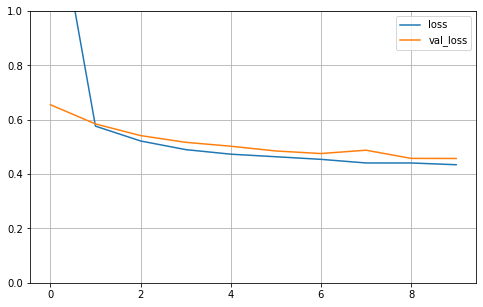

In [34]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [35]:
# sklearn 0.21.3版本可以用这种列表
# from scipy.stats import reciprocal
# param_distribution = {
#     "hidden_layers":[1, 2, 3, 4],
#     "layer_size": np.arange(1, 100),
#     "learning_rate": reciprocal(1e-4, 1e-2),
# }
# 最新版本只能用普通列表
param_distribution = {
    'hidden_layers': [1, 2, 3, 4],
    'layer_size': [5, 10, 20, 30],
    'learning_rate': [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# 交叉验证cross_validation: 训练集分成n份，n-1份训练，1份验证

In [36]:
# 随机搜索
random_search_cv=RandomizedSearchCV(sklearn_model,param_distribution)
random_search_cv.fit(x_train_scaled,y_train,
                     validation_data = (x_valid_scaled, y_valid),
                     epochs = 5,callbacks = callbacks,workers=-1)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model=random_search_cv.best_estimator_.model
print(model.evaluate(x_test_scaled,y_test))

Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.2738 - val_loss: 4.8750
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 4.2273 - val_loss: 3.9318
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 3.4483 - val_loss: 3.2331
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.8572 - val_loss: 2.7075
Epoch 5/5
73/73 [==============================] - 0s 762us/step - loss: 2.2554
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.4093 - val_loss: 5.2539
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.7471 - val_loss: 4.6216
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1888 - val_loss: 4.0823
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7109 - val_loss: 3.6134
Epoch 5/5
73/73 [==============================] - 0s 776us/step - loss: 3.1399
Epoch 1/5
291/291 [=============================

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4079 - val_loss: 0.4186
Epoch 5/5
73/73 [==============================] - 0s 942us/step - loss: 0.3975
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8171 - val_loss: 0.5350
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4760 - val_loss: 0.4512
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4209 - val_loss: 0.4107
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.3936 - val_loss: 0.3949
Epoch 5/5
73/73 [==============================] - 0s 818us/step - loss: 0.4197
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0309 - val_loss: 0.4880
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4181 - val_loss: 0.4010
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.3837 - val_loss: 0.3948
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 4.7905 - val_loss: 4.8804
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.5053 - val_loss: 4.5936
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.2354 - val_loss: 4.3227
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.9812 - val_loss: 4.0673
Epoch 5/5
73/73 [==============================] - 0s 693us/step - loss: 3.6905
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.5928 - val_loss: 4.4056
Epoch 2/5
291/291 [==============================] - 0s 974us/step - loss: 4.1170 - val_loss: 3.9505
Epoch 3/5
291/291 [==============================] - 0s 973us/step - loss: 3.7114 - val_loss: 3.5625
Epoch 4/5
291/291 [==============================] - 0s 980us/step - loss: 3.3635 - val_loss: 3.2286
Epoch 5/5
73/73 [==============================] - 0s 665us/step - loss: 2.9414
Epoch 1/5
291/291 [==============================] -

291/291 [==============================] - 0s 1ms/step - loss: 2.6019 - val_loss: 2.5260
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.0575 - val_loss: 2.1056
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 1.7473
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.0750 - val_loss: 5.0139
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4230 - val_loss: 4.3049
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7020 - val_loss: 3.5759
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0677 - val_loss: 2.9827
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 2.4510
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.7869 - val_loss: 1.0196
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8910 - val_loss: 0.8878
Epoch 3/5
291/291 [==============================] - 0s 1m

In [37]:
# 网格搜索
grid_search_cv =GridSearchCV(sklearn_model,param_distribution)
grid_search_cv.fit(x_train_scaled,y_train,
                     validation_data = (x_valid_scaled, y_valid),
                     epochs = 5,callbacks = callbacks,workers=-1)
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_estimator_)
model=grid_search_cv.best_estimator_.model
print(model.evaluate(x_test_scaled,y_test))

Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.9597 - val_loss: 4.5987
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.0191 - val_loss: 3.7687
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.3090 - val_loss: 3.1357
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.7629 - val_loss: 2.6433
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 2.0021
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 6.6023 - val_loss: 6.1860
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.1404 - val_loss: 4.9405
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1845 - val_loss: 4.0919
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5200 - val_loss: 3.4806
Epoch 5/5
73/73 [==============================] - 0s 928us/step - loss: 2.9100
Epoch 1/5
291/291 [=============================

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7920 - val_loss: 0.8267
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 0.7710
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.8782 - val_loss: 0.9518
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8206 - val_loss: 0.8155
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7458 - val_loss: 0.7750
Epoch 4/5
291/291 [==============================] - 0s 980us/step - loss: 0.7070 - val_loss: 0.7329
Epoch 5/5
73/73 [==============================] - 0s 693us/step - loss: 0.6235
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.3410 - val_loss: 0.6036
Epoch 2/5
291/291 [==============================] - 0s 991us/step - loss: 0.5593 - val_loss: 0.5319
Epoch 3/5
291/291 [==============================] - 0s 974us/step - loss: 0.4885 - val_loss: 0.5109
Epoch 4/5
291/291 [=======================

73/73 [==============================] - 0s 748us/step - loss: 2.1471
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 6.8539 - val_loss: 6.1495
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.2363 - val_loss: 4.9228
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.2360 - val_loss: 4.1316
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5794 - val_loss: 3.5855
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 3.0135
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.9530 - val_loss: 4.8668
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4460 - val_loss: 4.4031
Epoch 3/5
291/291 [==============================] - 0s 987us/step - loss: 4.0224 - val_loss: 4.0151
Epoch 4/5
291/291 [==============================] - 0s 961us/step - loss: 3.6667 - val_loss: 3.6899
Epoch 5/5
73/73 [==============================] - 0s 

Epoch 3/5
291/291 [==============================] - 0s 963us/step - loss: 0.5519 - val_loss: 0.5573
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4993 - val_loss: 0.5080
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 0.4802
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.3186 - val_loss: 0.7107
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6050 - val_loss: 0.6053
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5374 - val_loss: 0.5551
Epoch 4/5
291/291 [==============================] - 0s 970us/step - loss: 0.5018 - val_loss: 0.5223
Epoch 5/5
73/73 [==============================] - 0s 706us/step - loss: 0.4846
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.0826 - val_loss: 0.7525
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6250 - val_loss: 0.6020
Epoch 3/5
291/291 [=========================

73/73 [==============================] - 0s 720us/step - loss: 2.8542
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.0364 - val_loss: 4.8832
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.5364 - val_loss: 4.4011
Epoch 3/5
291/291 [==============================] - 0s 980us/step - loss: 4.1120 - val_loss: 3.9912
Epoch 4/5
291/291 [==============================] - 0s 998us/step - loss: 3.7485 - val_loss: 3.6401
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 3.3504
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.3359 - val_loss: 5.2648
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.6258 - val_loss: 4.5992
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.0546 - val_loss: 4.0611
Epoch 4/5
291/291 [==============================] - 0s 998us/step - loss: 3.5907 - val_loss: 3.6195
Epoch 5/5
73/73 [==============================] - 0

Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7806 - val_loss: 0.5568
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4978 - val_loss: 0.5094
Epoch 4/5
291/291 [==============================] - 0s 935us/step - loss: 0.4877 - val_loss: 0.5899
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 0.4495
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.7925 - val_loss: 0.7732
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 1.1606 - val_loss: 0.5350
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4577 - val_loss: 0.4648
Epoch 4/5
291/291 [==============================] - 0s 994us/step - loss: 0.4191 - val_loss: 0.4349
Epoch 5/5
73/73 [==============================] - 0s 665us/step - loss: 0.4123
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.8007 - val_loss: 0.8075
Epoch 2/5
291/291 [=========================

291/291 [==============================] - 0s 1ms/step - loss: 0.7131 - val_loss: 0.7539
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 0.6572
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 2.4886 - val_loss: 1.0932
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8617 - val_loss: 0.8337
Epoch 3/5
291/291 [==============================] - 0s 990us/step - loss: 0.7583 - val_loss: 0.7970
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7223 - val_loss: 0.7643
Epoch 5/5
73/73 [==============================] - 0s 707us/step - loss: 0.6801
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 3.0294 - val_loss: 1.3439
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9576 - val_loss: 0.8498
Epoch 3/5
291/291 [==============================] - 0s 977us/step - loss: 0.7510 - val_loss: 0.7737
Epoch 4/5
291/291 [==============================] - 0

291/291 [==============================] - 1s 1ms/step - loss: 6.2157 - val_loss: 5.9674
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.2382 - val_loss: 5.0965
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4806 - val_loss: 4.4054
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.8757 - val_loss: 3.8447
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 3.2248
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.7100 - val_loss: 4.4891
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.9127 - val_loss: 3.7397
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.2625 - val_loss: 3.1202
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.7329 - val_loss: 2.6183
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 2.0796
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5639 - val_loss: 0.5679
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 0.4803
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.3828 - val_loss: 0.7211
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6008 - val_loss: 0.5786
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5198 - val_loss: 0.5235
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4841 - val_loss: 0.4918
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 0.4674
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.3659 - val_loss: 0.8161
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7041 - val_loss: 0.7232
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6205 - val_loss: 0.6337
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 6.5126 - val_loss: 6.3396
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.6553 - val_loss: 5.5560
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.9779 - val_loss: 4.9238
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4226 - val_loss: 4.4016
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 3.5462
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 3.8816 - val_loss: 3.8774
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5266 - val_loss: 3.5431
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.2306 - val_loss: 3.2625
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.9796 - val_loss: 3.0242
Epoch 5/5
73/73 [==============================] - 0s 693us/step - loss: 2.6972
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4882 - val_loss: 0.5279
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 0.4794
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.9346 - val_loss: 0.7147
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6094 - val_loss: 0.6038
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5392 - val_loss: 0.5405
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4995 - val_loss: 0.5008
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 0.4208
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.0897 - val_loss: 0.6831
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6077 - val_loss: 0.6085
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5465 - val_loss: 0.5243
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 5.8256 - val_loss: 5.5952
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.8475 - val_loss: 4.7293
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1326 - val_loss: 4.0805
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5926 - val_loss: 3.5814
Epoch 5/5
73/73 [==============================] - 0s 693us/step - loss: 3.0874
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 2.3088 - val_loss: 0.8853
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7073 - val_loss: 0.6907
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6349 - val_loss: 0.6574
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6099 - val_loss: 0.6336
Epoch 5/5
73/73 [==============================] - 0s 706us/step - loss: 0.5486
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4123 - val_loss: 0.4332
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 0.4179
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.9427 - val_loss: 0.5743
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5280 - val_loss: 0.5071
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4465 - val_loss: 0.4617
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4240 - val_loss: 0.4402
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 0.4290
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.7184 - val_loss: 4.2101
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5494 - val_loss: 3.1779
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.6916 - val_loss: 2.4330
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 2.1751 - val_loss: 1.0725
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8004 - val_loss: 0.7372
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6338 - val_loss: 0.6818
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5971 - val_loss: 0.6578
Epoch 5/5
73/73 [==============================] - 0s 750us/step - loss: 0.6215
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.5861 - val_loss: 0.9808
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7753 - val_loss: 0.7963
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6923 - val_loss: 0.7380
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6493 - val_loss: 0.7047
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 0.6317
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7743 - val_loss: 3.7771
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 3.2495
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.6436 - val_loss: 4.5016
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.0280 - val_loss: 3.9291
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5142 - val_loss: 3.4556
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0957 - val_loss: 3.0758
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 2.6692
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.4822 - val_loss: 5.2822
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.5385 - val_loss: 4.4044
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7644 - val_loss: 3.6703
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 1.7063 - val_loss: 1.0531
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7894 - val_loss: 0.7224
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6373 - val_loss: 0.6675
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5965 - val_loss: 0.6307
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 0.5586
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 2.1075 - val_loss: 1.3414
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 1.1186 - val_loss: 0.9722
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8199 - val_loss: 0.7817
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7004 - val_loss: 0.6872
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 0.5945
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.8868 - val_loss: 2.9269
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 2.4434
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.4718 - val_loss: 5.4772
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.9726 - val_loss: 4.9897
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.5201 - val_loss: 4.5411
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1011 - val_loss: 4.1219
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 3.5824
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 5.3238 - val_loss: 5.3652
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.9961 - val_loss: 5.0363
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.6816 - val_loss: 4.7145
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 1.0503 - val_loss: 0.7596
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6442 - val_loss: 0.6205
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5582 - val_loss: 0.5500
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4945 - val_loss: 0.5220
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 0.4814
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.8596 - val_loss: 0.6031
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5205 - val_loss: 0.5771
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4726 - val_loss: 0.4734
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4391 - val_loss: 0.4759
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 0.4262
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6451 - val_loss: 0.6628
Epoch 5/5
73/73 [==============================] - 0s 749us/step - loss: 0.5544
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.9591 - val_loss: 0.9244
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7533 - val_loss: 0.7107
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6476 - val_loss: 0.6560
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5990 - val_loss: 0.6202
Epoch 5/5
73/73 [==============================] - 0s 748us/step - loss: 0.5506
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.6348 - val_loss: 0.9917
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8573 - val_loss: 0.8437
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7618 - val_loss: 0.7831
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 5.7479 - val_loss: 5.1045
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.2588 - val_loss: 3.8277
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.1943 - val_loss: 2.8725
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.3950 - val_loss: 2.1650
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 1.4988
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 3.9404 - val_loss: 3.4328
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 2.7541 - val_loss: 2.3832
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 1.9263 - val_loss: 1.6919
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.4147 - val_loss: 1.2935
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 1.0069
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6609 - val_loss: 0.7009
Epoch 5/5
73/73 [==============================] - 0s 679us/step - loss: 0.6551
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.9600 - val_loss: 0.6220
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5454 - val_loss: 0.5300
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4878 - val_loss: 0.4844
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4523 - val_loss: 0.4521
Epoch 5/5
73/73 [==============================] - 0s 707us/step - loss: 0.3814
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.1281 - val_loss: 0.6546
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5547 - val_loss: 0.5438
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4827 - val_loss: 0.4935
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 5.3149 - val_loss: 5.3239
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.8346 - val_loss: 4.8852
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4372 - val_loss: 4.5042
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.0888 - val_loss: 4.1679
Epoch 5/5
73/73 [==============================] - 0s 734us/step - loss: 3.7748
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.9814 - val_loss: 4.5203
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.8374 - val_loss: 3.5566
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0415 - val_loss: 2.8818
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.4938 - val_loss: 2.4257
Epoch 5/5
73/73 [==============================] - 0s 707us/step - loss: 1.8805
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5304 - val_loss: 0.5654
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 0.5038
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.7234 - val_loss: 1.3103
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 1.1030 - val_loss: 0.9413
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7037 - val_loss: 0.6243
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5498 - val_loss: 0.5405
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 0.5048
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.9296 - val_loss: 0.6478
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5825 - val_loss: 0.5679
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5343 - val_loss: 0.5364
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 4.7325 - val_loss: 4.4499
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.8213 - val_loss: 3.5467
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0186 - val_loss: 2.7826
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.3573 - val_loss: 2.1760
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 1.6094
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.2466 - val_loss: 4.1457
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.6636 - val_loss: 3.5500
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.1393 - val_loss: 3.0247
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.6893 - val_loss: 2.5780
Epoch 5/5
73/73 [==============================] - 0s 721us/step - loss: 2.1202
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4080 - val_loss: 0.4198
Epoch 5/5
73/73 [==============================] - 0s 762us/step - loss: 0.3916
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.2011 - val_loss: 0.7665
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6483 - val_loss: 0.6758
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5731 - val_loss: 0.6036
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5186 - val_loss: 0.5708
Epoch 5/5
73/73 [==============================] - 0s 694us/step - loss: 0.4821
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 0.9807 - val_loss: 0.5398
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4567 - val_loss: 0.4521
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4063 - val_loss: 0.4296
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 2.7720 - val_loss: 1.1289
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9124 - val_loss: 0.8453
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7779 - val_loss: 0.7872
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7297 - val_loss: 0.7588
Epoch 5/5
73/73 [==============================] - 0s 735us/step - loss: 0.6846
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 2.3724 - val_loss: 1.0862
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9008 - val_loss: 0.7843
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7134 - val_loss: 0.7018
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6652 - val_loss: 0.6757
Epoch 5/5
73/73 [==============================] - 0s 803us/step - loss: 0.6171
Epoch 1/5
291/291 [==============================] - 1s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.2603 - val_loss: 2.1119
Epoch 5/5
73/73 [==============================] - 0s 693us/step - loss: 1.5429
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.4155 - val_loss: 4.0623
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.3576 - val_loss: 3.0573
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.4964 - val_loss: 2.3097
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.9168 - val_loss: 1.8565
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 1.4708
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 4.6108 - val_loss: 4.2461
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.6279 - val_loss: 3.2811
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.7518 - val_loss: 2.4449
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 1ms/step - loss: 0.9013 - val_loss: 0.5820
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4986 - val_loss: 0.5026
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4401 - val_loss: 0.4486
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4122 - val_loss: 0.4246
Epoch 5/5
73/73 [==============================] - 0s 722us/step - loss: 0.4050
Epoch 1/5
291/291 [==============================] - 1s 1ms/step - loss: 1.1606 - val_loss: 0.6329
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5458 - val_loss: 0.5248
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4716 - val_loss: 0.4707
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4345 - val_loss: 0.4592
Epoch 5/5
73/73 [==============================] - 0s 720us/step - loss: 0.4095
Epoch 1/5
291/291 [==============================] - 1s 1m